In [1]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.ssplines_R as ssplinesR
from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd
import json

  Convergence criterion reached in 20 iterations.
  Convergence criterion reached in 21 iterations.


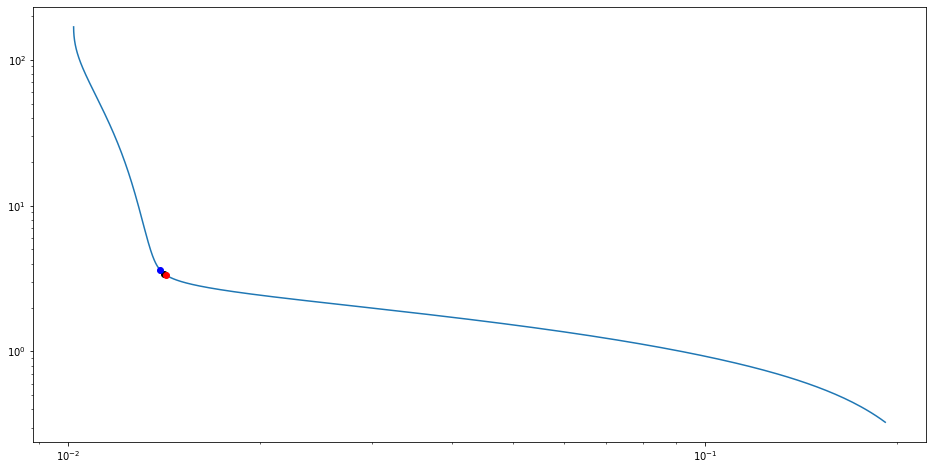

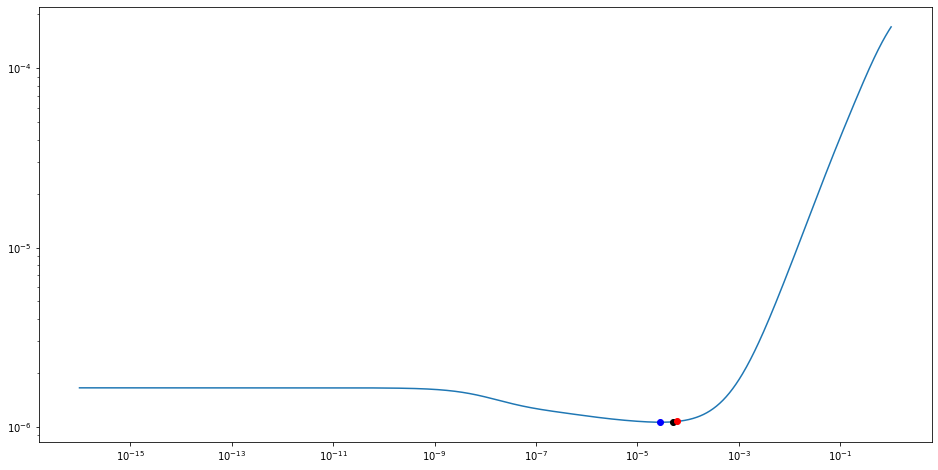

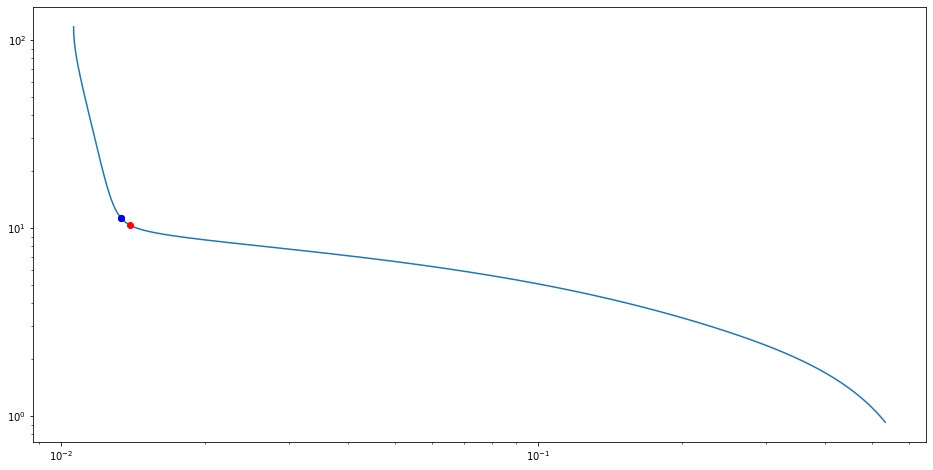

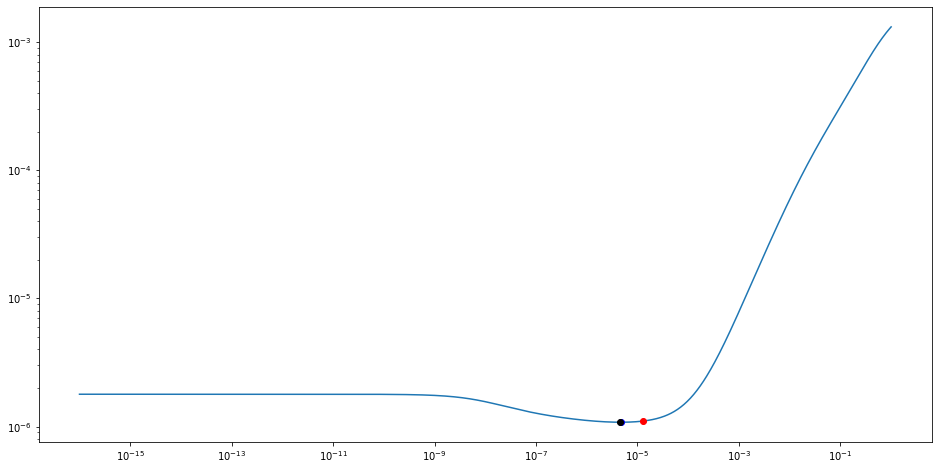

In [12]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/VanderPol_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)

noise_lvl = 0.001

write_data = True

## Select realization
sample = 0

##Range of lambdas
lambda_min = 1e-16
lambda_max = 1
n_lambdas = 1000

#Vreate dictionary to store values
lcurve_dict = {}
gcv_dict = {}


# LOAD OBSERVATION SAMPLES
Y_samples = []

for state in range(n_states):

    filepath = 'data_files/VanderPol_samples_noise_' + str(noise_lvl) +'_Y'+ str(state+1) + '.csv'
    y = np.genfromtxt(filepath, delimiter=',')

    Y_samples.append(y)

n_samples = Y_samples[0].shape[0]

################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
# trim = int(np.floor(5 / 100 * t_samples))
# tt_samples = t_samples - 2 * trim


for state in range(n_states):

    y = Y_samples[state][sample,:]

    #L-CURVE
    ss_flc = ssplinesR.full_lcurve(y, t, lambda_min, lambda_max, n_lambdas = n_lambdas)
    ss_path = ss_flc[0]
    res, reg = ss_flc[2]
    error_path = np.zeros(ss_path.shape[1])
    for i in range(ss_path.shape[1]):
        error_path[i] = norm(ss_path[:,i] - X[state,:]) / norm(X[state,:])

    min_indx_lc = np.argmin(error_path)
    res_min = res[min_indx_lc]
    reg_min = reg[min_indx_lc]

    #Find corner point
    ss_lc = ssplinesR.lcurve_corner(y, t, lambda_min, lambda_max)
    y_ss = ss_lc[0]
    dy_ss = ss_lc[1]
    res_lc, reg_lc = ss_lc[4]
    lambda_lc = ss_lc[2]

    #GCV
    ss_gcv = ssplinesR.gcv(y, t, lambda_min, lambda_max, n_lambdas = n_lambdas)
    lambdas, gcv_lambda = ss_gcv[2]
    min_gcv_indx = np.argmin(gcv_lambda)
    min_gcv = np.min(gcv_lambda)
    min_gcv_lambda = lambdas[min_gcv_indx] 

    y_ss_path = ss_gcv[3]

    error_path_gcv = np.zeros(y_ss_path.shape[1])
    for i in range(y_ss_path.shape[1]):
        error_path_gcv[i] = norm(y_ss_path[:,i] - X[state,:]) / norm(X[state,:])
    min_indx_error_gcv = np.argmin(error_path_gcv) 
    min_error_gcv_gcv = gcv_lambda[min_indx_error_gcv]
    min_error_gcv_lambda = lambdas[min_indx_error_gcv]

    #Solve for optimal gcv lambda
    ss_gcv_opt = ssplinesR.ssplines(y, t, lambd = min_gcv_lambda)
    res_gcv, reg_gcv = ss_gcv_opt[1]

    #Solve for optimal Lcurve lambda
    ss_lc_opt = ssplinesR.ssplines(y, t, lambd = lambda_lc)
    gcv_lc = ss_lc_opt[2][0]


    plt.figure(figsize = (16,8))
    plt.loglog(res, reg)
    plt.loglog(res_min, reg_min,'ko')
    plt.loglog(res_lc[-1], reg_lc[-1], 'ro')
    plt.loglog(res_gcv, reg_gcv, 'bo')

    lcurve_dict[f'state{state+1}:residual'] = res.tolist()
    lcurve_dict[f'state{state+1}:regularizer'] = reg.tolist()
    lcurve_dict[f'state{state+1}:res_corner'] = res_lc[-1]
    lcurve_dict[f'state{state+1}:reg_corner'] = reg_lc[-1]
    lcurve_dict[f'state{state+1}:res_min'] = res_min
    lcurve_dict[f'state{state+1}:reg_min'] = reg_min
    lcurve_dict[f'state{state+1}:res_gcv'] = res_gcv
    lcurve_dict[f'state{state+1}:reg_gcv'] = reg_gcv

    plt.figure(figsize = (16,8))
    plt.loglog(lambdas, gcv_lambda)
    plt.loglog(min_gcv_lambda, min_gcv, 'bo')
    plt.loglog(min_error_gcv_lambda, min_error_gcv_gcv, 'ko')
    plt.loglog(lambda_lc, gcv_lc, 'ro')

    gcv_dict[f'state{state+1}:lambdas'] = lambdas.tolist()
    gcv_dict[f'state{state+1}:gcv_func'] = gcv_lambda.tolist()
    gcv_dict[f'state{state+1}:lambda_lcurve'] = lambda_lc.tolist()
    gcv_dict[f'state{state+1}:gcv_lcurve'] = gcv_lc.tolist()
    gcv_dict[f'state{state+1}:min_error_lambda'] = min_error_gcv_lambda
    gcv_dict[f'state{state+1}:min_error_gcv'] = min_error_gcv_gcv
    gcv_dict[f'state{state+1}:min_lambda'] = min_gcv_lambda
    gcv_dict[f'state{state+1}:min_gcv'] = min_gcv

In [13]:
if write_data:
    # STORE LCURVE IN JSON FORMAT
    filename_lc = 'lcurve_' + str(noise_lvl) + '.json'
    filepath_lc = 'data_files/ssplines/' + filename_lc
    with open(filepath_lc, "w") as outfile:  
        json.dump(lcurve_dict, outfile)  

    # STORE GCV IN JSON FORMAT
    filename_gcv = 'gcv_' + str(noise_lvl) + '.json'
    filepath_gcv = 'data_files/ssplines/' + filename_gcv
    with open(filepath_gcv, "w") as outfile:  
        json.dump(gcv_dict, outfile) 